<a href="https://colab.research.google.com/github/iwassily/pix2pix/blob/main/NN_baseline_4_sub_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT etc

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm.notebook import tqdm

%matplotlib inline
from itertools import combinations

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR, MultiStepLR
import torchvision.transforms as tt

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab_Notebooks/Competitions/YandexCup2021RecSys

[Errno 2] No such file or directory: 'drive/MyDrive/Colab_Notebooks/Competitions/YandexCup2021RecSys'
/content/drive/MyDrive/Colab_Notebooks/Competitions/YandexCup2021RecSys


# Что делаем

решаем подзадачу:
- рекомендации только внутри города для его жителей
- строим эмбеддинги только для заведений, так чтобы
- заведения, которые часто встречаются в одном наборе(т.е. у одного пользователя) были близки в этом векторном пр-ве
- по контексту(сумме из набора) предсказываем ещё одно заведение, CBOW

но для начала пробуем без разделения на города

# Данные

In [ ]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

In [ ]:
users = pd.read_csv('data/users.csv')

orgs = pd.read_csv('data/organisations.csv')
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

reviews = pd.read_csv('data/reviews.csv', low_memory=False)

reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# Dataloader и вся для него

**пока учимся на всех данных**



In [ ]:
def clear_df(df, suffixes=['_x', '_y'], inplace=True):
    '''
    clear_df(df, suffixes=['_x', '_y'], inplace=True)
        Удаляет из входного df все колонки, оканчивающиеся на заданные суффиксы. 
        
        Parameters
        ----------
        df : pandas.DataFrame
        
        suffixies : Iterable, default=['_x', '_y']
            Суффиксы колонок, подлежащих удалению
            
        inplace : bool, default=True
            Нужно ли удалить колонки "на месте" или же создать копию DataFrame.
            
        Returns
        -------
        pandas.DataFrame (optional)
            df с удалёнными колонками
    '''
    
    def bad_suffix(column):
        nonlocal suffixes
        return any(column.endswith(suffix) for suffix in suffixes)
        
    columns_to_drop = [col for col in df.columns if bad_suffix(col)]
    return df.drop(columns_to_drop, axis=1, inplace=inplace)


def extract_unique(reviews, column): 
    '''
    extract_unique(reviews, column)
        Извлекает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит одну именованную колонку с уникальными значениями. 
    '''
    
    unique = reviews[column].unique()
    return pd.DataFrame({column: unique})


def count_unique(reviews, column):
    '''
    count_unique(reviews, column)
        Извлекает и подсчитывает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит две колонки: с уникальными значениями и счётчиком встреченных. 
    '''
    
    return reviews[column].value_counts().reset_index(name='count').rename({'index': column}, axis=1)



def filter_reviews(reviews, users=None, orgs=None): 
    '''
    filter_reviews(reviews, users=None, orgs=None)
    Оставляет в выборке только отзывы, оставленные заданными пользователями на заданные организации. 
    
    Parameters
    ----------
        users: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <user_id>.
            Если None, то фильтрация не происходит. 
            
        orgs: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <org_id>.
            Если None, то фильтрация не происходит. 
    
    Returns
    -------
        pandas.DataFrame
            Отфильтрованная выборка отзывов. 

    '''
    if users is not None: 
        reviews = reviews.merge(users, on='user_id', how='inner')
        clear_df(reviews)
        
    if orgs is not None:
        reviews = reviews.merge(orgs, on='org_id', how='inner')
        clear_df(reviews)
        
    return reviews


def train_test_split(reviews, ts_start, ts_end=None):
    '''
    train_test_split(reviews, ts_start, ts_end=None)
        Разделяет выборку отзывов на две части: обучающую и тестовую. 
        В тестовую выборку попадают только отзывы с user_id и org_id, встречающимися в обучающей выборке.

        Parameters
        ----------
        reviews : pandas.DataFrame 
            Отзывы из reviews.csv с обязательными полями:
                <rating>, <ts>, <user_id>, <user_city>, <org_id>, <org_city>.

        ts_start : int
            Первый день отзывов из тестовой выборки (включительно).

        ts_end : int, default=None
            Последний день отзывов из обучающей выборки (включительно)
            Если параметр равен None, то ts_end == reviews['ts'].max(). 

        Returns
        -------
        splitting : tuple
            Кортеж из двух pandas.DataFrame такой же структуры, как и reviews:
            в первом отзывы, попавшие в обучающую выборку, во втором - в тестовую.
    '''
    
    if not ts_end:
        ts_end = reviews['ts'].max()
    
    
    reviews_train = reviews[(reviews['ts'] < ts_start) | (reviews['ts'] > ts_end)]
    reviews_test = reviews[(ts_start <= reviews['ts']) & (reviews['ts'] <= ts_end)]
    
    # 1. Выбираем только отзывы на понравившиеся места у путешественников
    reviews_test = reviews_test[reviews_test['rating'] >= 4.0]
    reviews_test = reviews_test[reviews_test['user_city'] != reviews_test['org_city']]
    
    # 2. Оставляем в тесте только тех пользователей и организации, которые встречались в трейне
    train_orgs = extract_unique(reviews_train, 'org_id')
    train_users = extract_unique(reviews_train, 'user_id')
    
    reviews_test = filter_reviews(reviews_test, orgs=train_orgs)

    return reviews_train, reviews_test


def process_reviews(reviews):
    '''
    process_reviews(reviews)
        Извлекает из набора отзывов тестовых пользователей и таргет. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            DataFrame с отзывами, содержащий колонки <user_id> и <org_id>
        
        Returns
        -------
        X : pandas.DataFrame
            DataFrame такой же структуры, как и в test_users.csv
            
        y : pandas.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список org_id, посещённых пользователем. 
    '''
    
    y = reviews.groupby('user_id')['org_id'].apply(list).reset_index(name='target')
    X = pd.DataFrame(y['user_id'])
    
    return X, y

In [ ]:
def MNAP(size=20):
    '''
    MNAP(size=20)
        Создаёт метрику под <size> сделанных предсказаний.
        
        Parameters
        ----------
        size : int, default=20
            Размер рекомендованной выборки для каждого пользователя
        
        Returns
        -------
        func(pd.DataFrame, pd.DataFrame) -> float
            Функция, вычисляющая MNAP.
        
    '''
    
    assert size >= 1, "Size must be greater than zero!"
    
    def metric(y_true, predictions, size=size):
        '''
        metric(y_true, predictions, size=size)
            Метрика MNAP для двух перемешанных наборов <y_true> и <y_pred>.
            
            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список настоящих org_id, посещённых пользователем. 
                
            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список рекомендованных для пользователя org_id.
                
            Returns
            -------
            float 
                Значение метрики.
        '''
        
        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')
        
        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')
    
        def score(x, size=size):
            '''
            Вспомогательная функция.
            '''
            
            
            y_true = x[1][1]
            predictions = x[1][2][:size]
            
            weight = 0
            
            inner_weights = [0]
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)
            
            for n, item in enumerate(predictions):                
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)
                    
            return weight / min(len(y_true), size)
    
        return np.mean([score(row) for row in merged.iterrows()])
    
        
    return metric


def print_score(score):
    print(f"Score: {score*100.0:.2f}")
    
    
N = 20
MNAP_N = MNAP(N)

In [ ]:
#reviews_sub_task_msk = reviews[(reviews.user_city == 'msk') & (reviews.org_city == 'msk')]
#**потом - выбираем только ту часть, где москвичи оставляли отзывы на московские места**

In [ ]:
'''
ser = reviews_sub_task_msk.user_id.value_counts()
for k in range(1,11):
    fraction = ser.value_counts(normalize=True).values[0:k].sum()
    print('{:.2f} часть пользователей оставили {} или менее резензий'.format(fraction, k))
'''

"\nser = reviews_sub_task_msk.user_id.value_counts()\nfor k in range(1,11):\n    fraction = ser.value_counts(normalize=True).values[0:k].sum()\n    print('{:.2f} часть пользователей оставили {} или менее резензий'.format(fraction, k))\n"

**гиперпараметр 1: отсечка по числу рецензий.**

**для обучения берем пользователей, которые оставили R или более штук рецензий**

In [ ]:
R=2 

**стратегии для сэмплирования могут быть оч разные**

**гиперпараметр 2: сколько заведений брать в набор. все? 2, 4?**

**делае ли negative sampling**

**если да, то какой?**

**хотим users_data - где в строчке user_id и лист мест, которым он поставил оценки 4 и 5, листы длины 2 и более**

In [ ]:
print(users_data[users_data.num_reviews > 1].shape[0]/users.user_id.nunique())
print('доля пользователей от всех, которые оставили хотя бы две положительные оценки')

NameError: ignored

In [ ]:
train_reviews, val_reviews = train_test_split(reviews, 1116)
X_val, y_val = process_reviews(val_reviews)

In [ ]:
org2ind = {r: i+1 for i,r in enumerate(train_reviews.org_id.unique())}

In [ ]:
train_reviews['org_id'] = train_reviews['org_id'].map(org2ind.get)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def get_pairs(reviews_df, R=2):
    reviews_df = reviews_df[reviews_df.rating >= 4]
    #reviews_df.drop(columns=['rating', 'ts', 'aspects', 'user_city', 'org_city'], inplace=True)
    reviews_df = pd.DataFrame(reviews_df.groupby('user_id')['org_id'].unique())
    reviews_df['num_reviews'] = reviews_df.org_id.apply(lambda x: len(x))
    reviews_df = reviews_df[reviews_df.num_reviews >= R]
    pairs = []
    for x in  reviews_df.org_id.apply(lambda x: list(combinations(x, 2))):
        pairs.extend(x)
    return pairs

In [ ]:
class pair_dataset():
    def __init__(self, pairs):
        self.data = pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.data[idx][0], dtype=torch.long),
            'target': torch.tensor(self.data[idx][1], dtype=torch.long)
          }
        

In [ ]:
train_pairs = get_pairs(train_reviews)

In [ ]:
train_pairs_ds = pair_dataset(train_pairs)

In [ ]:
train_dataloader = DataLoader(train_pairs_ds, 
                              batch_size=512,
                              shuffle=True)

# Trainer, Model

In [ ]:
class Org2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        #self.relu = nn.ReLU(inplace=False)
        self.W1 = nn.Linear(embedding_size, vocab_size)
        #nn.init.xavier_normal_(self.W1.weight)

    def forward(self, x):
        x = self.embed(x)
        x = self.W1(x)

        return x

In [ ]:
class Org2Vec_trainer(object):
    def __init__(self, model, loader, device='cuda'):
        super().__init__()
        self.model = model 
        self.loader = loader
        self.device = device
        self.model.to(self.device)

        self.loss = nn.CrossEntropyLoss()
        self.losses_train = []  

    def plot_losses(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.losses_train, '-', label='loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss');
        plt.legend()
        plt.show()

    def fit_one_epoch(self):
        epoch_loss = 0
        for batch in tqdm(self.loader):
            x = batch['input_ids'].to(self.device)
            y = batch['target'].to(self.device)
            self.optimizer.zero_grad()
            predictions = self.model(x)
            #print(labels.shape, 'labels')
            #print(predictions.shape, 'preds')
            loss = self.loss(predictions, y)

            loss.backward()
            self.optimizer.step()
            #self.scheduler.step()
            epoch_loss += loss.item()

        return epoch_loss/len(self.loader)


    def fit(self, epochs, epochs_to_average=5, lr=0.0003, print_each_epoch=True):
    
        self.optimizer = Adam(self.model.parameters(), lr=lr)
        self.model.train()
        

        for epoch in range(epochs):
            loss = self.fit_one_epoch()
            self.losses_train.append(loss)


            if (print_each_epoch==True or epoch == epochs-1):
                print("Epoch [{}/{}], loss: {:.5f}, ".format(epoch+1, epochs, loss))

In [ ]:
def reduce_to_2d(M, k=2, method='svd'):
    methods = {'svd': TruncatedSVD(), 'tsne': TSNE(n_components=k, n_iter=250)}
    reducer = methods[method]
    M_reduced = reducer.fit_transform(M)
    return M_reduced

def reduce_to_k_dim_tsne(M, k=2):
    tsne = TSNE(n_components=k, n_iter=250)
    M_reduced = tsne.fit_transform(M)
    return M_reduced
def plot_embeddings(M_reduced):
    plt.figure(figsize=(15, 15))
    x = M_reduced[:, 0]
    y = M_reduced[:, 1]
    plt.scatter(x, y, marker='.', color='blue', s = 0.2)
    plt.show()

In [ ]:
model = Org2Vec(len(org2ind), 50)

In [ ]:
trainer = Org2Vec_trainer(model, train_dataloader)

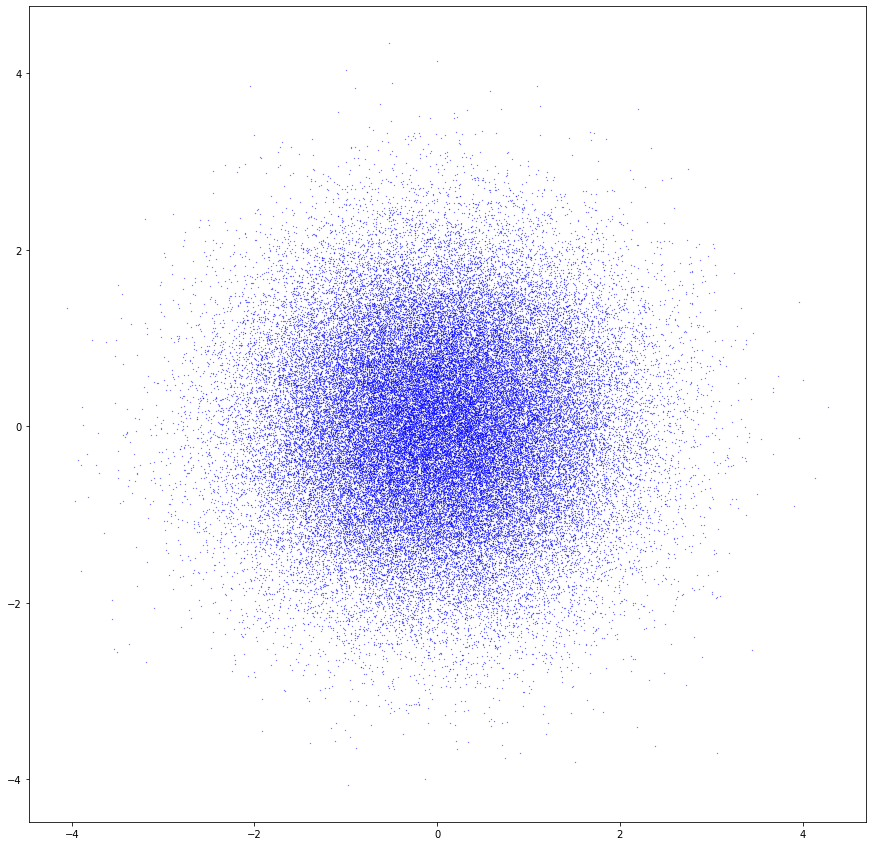

In [ ]:
embeddings = model.embed.weight.data.detach().cpu().numpy()
embeddings_svd = reduce_to_2d(embeddings)
plot_embeddings(embeddings_svd)

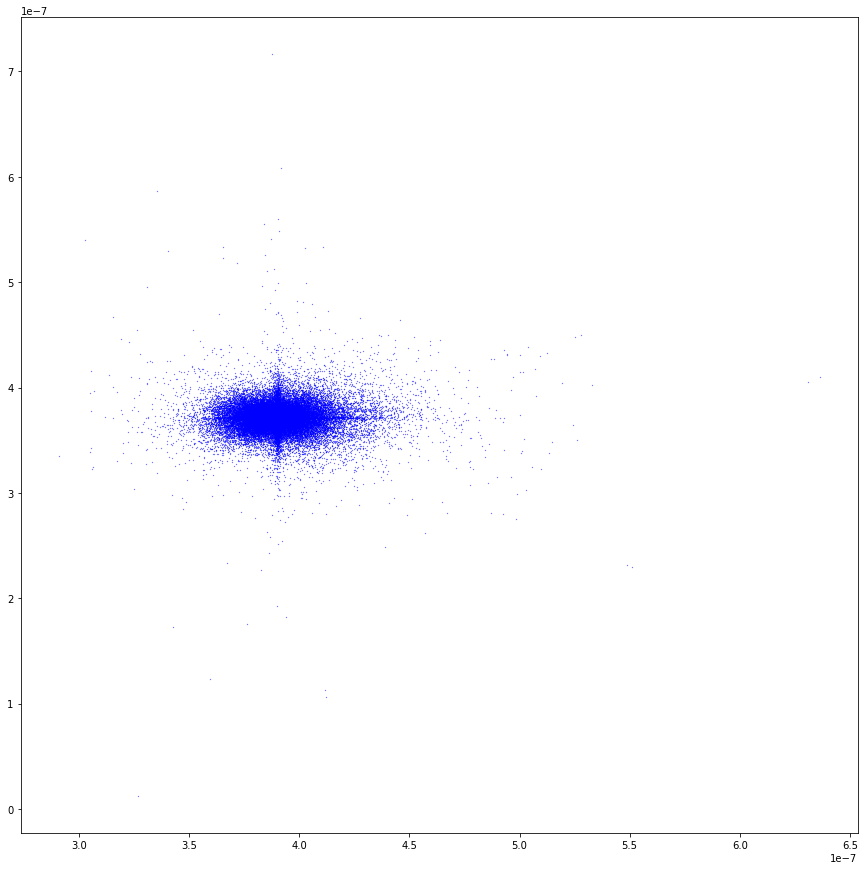

CPU times: user 10min 16s, sys: 34.9 ms, total: 10min 16s
Wall time: 10min 13s


In [ ]:
%%time
embeddings = model.embed.weight.data.detach().cpu().numpy()
embeddings_tsne = reduce_to_2d(embeddings, method='tsne')
plot_embeddings(embeddings_tsne)

In [ ]:
%%time
trainer.fit(10)

  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [1/10], loss: 9.87433, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [2/10], loss: 9.20152, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [3/10], loss: 8.99100, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [4/10], loss: 8.85993, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [5/10], loss: 8.77028, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [6/10], loss: 8.70584, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [7/10], loss: 8.65691, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [8/10], loss: 8.61809, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [9/10], loss: 8.58609, 


  0%|          | 0/18566 [00:00<?, ?it/s]

Epoch [10/10], loss: 8.55911, 
CPU times: user 43min 42s, sys: 53.5 s, total: 44min 36s
Wall time: 44min 7s


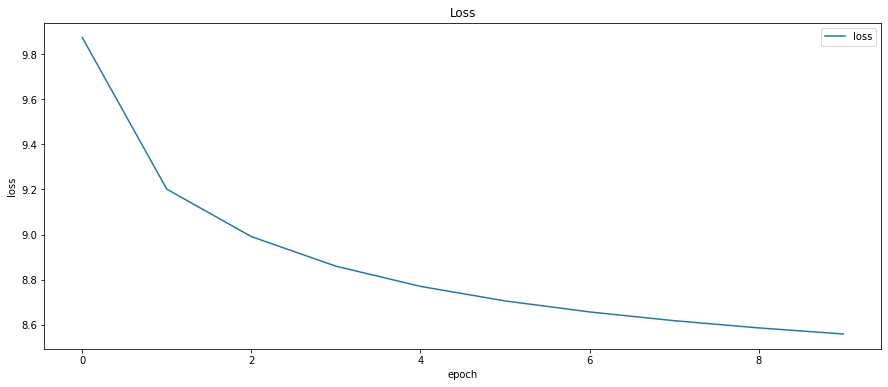

In [ ]:
trainer.plot_losses()

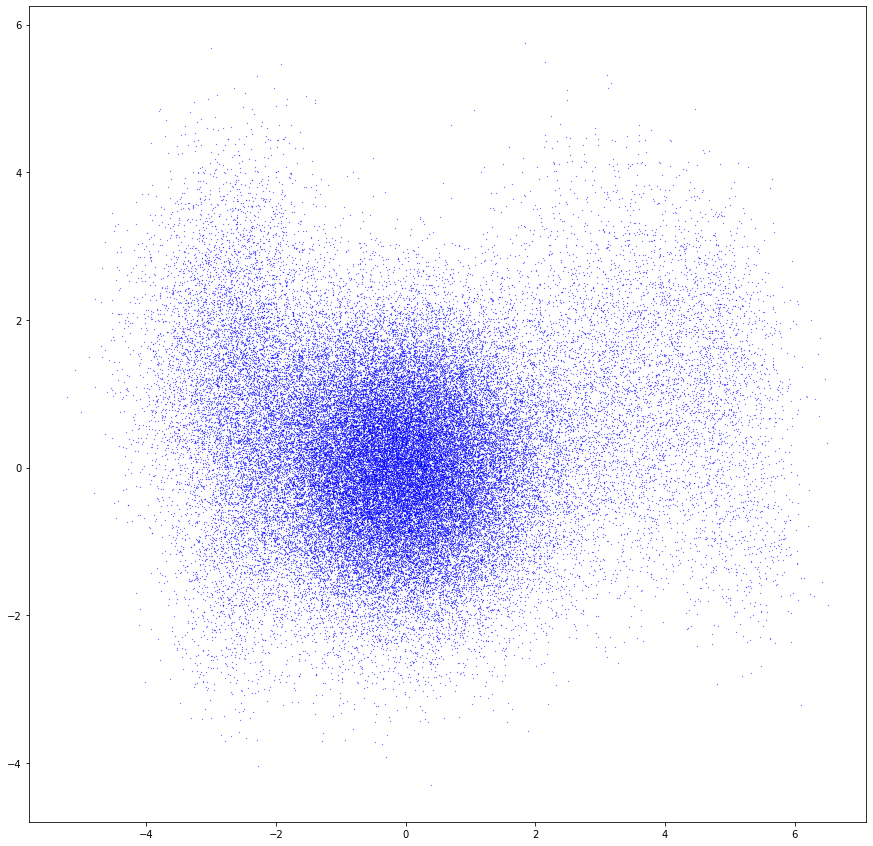

In [ ]:
embeddings = model.embed.weight.data.detach().cpu().numpy()
embeddings_svd = reduce_to_2d(embeddings)
plot_embeddings(embeddings_svd)

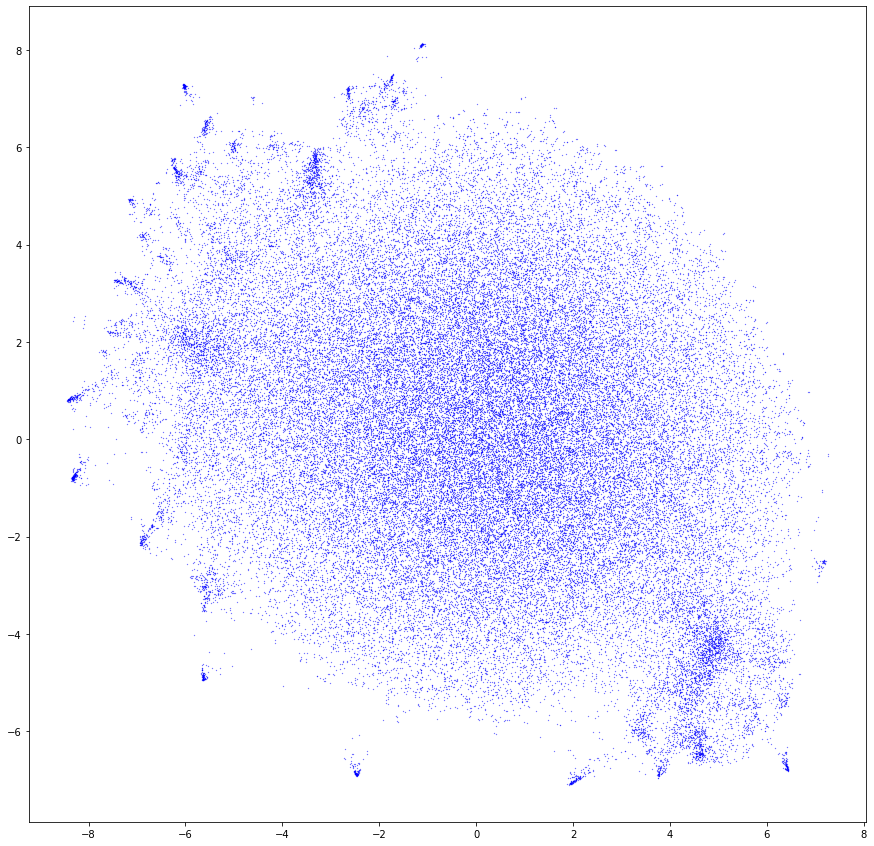

CPU times: user 14min 6s, sys: 816 ms, total: 14min 7s
Wall time: 14min 3s


In [ ]:
%%time
embeddings = model.embed.weight.data.detach().cpu().numpy()
embeddings_tsne = reduce_to_2d(embeddings, method='tsne')
plot_embeddings(embeddings_tsne)